# Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.applications import VGG16
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# **Filter Maximization**

In [ ]:
# loading model
model = VGG16(include_top = False)
#model.trainable = False


58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# creating new model of intermediate layer
layer_output = model.get_layer('block5_conv3').output
activation = models.Model(model.input,layer_output)# new model

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
# initializing image which to be sent to model
def init_img():

  image = tf.random.uniform((1, 150,150, 3))
  image = (image-0.5)*0.25
  return image


In [ ]:
# defining loss for filter visualisation here we will maximize loss
def vis_loss(image,filter_index):
  
  
  feature = activation(image)
  loss = tf.math.reduce_mean(feature[:,2:-2,2:-2,filter_index])
  return loss

In [ ]:
# defining gradient descent for image visualization
def gradient(image,filter_index):
  for i in range(30):
    with tf.GradientTape()as tape:
        tape.watch(image)
        loss = vis_loss(image,filter_index)
    grads = tape.gradient(loss,image)
    grads = tf.math.l2_normalize(grads)

    image+=10*grads
    return loss,image
  
  
  

In [ ]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Function to display input which maximize activation of filter 

In [ ]:
def visualization_filter(filter_index):
  
  image=init_img()
  for i in range(30):
    loss,image = gradient(image,filter_index)
  img =deprocess_image(image[0].numpy())
  plt.imshow(img)


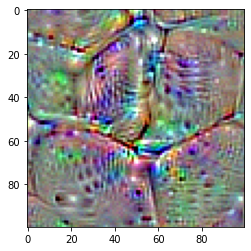

In [ ]:
visualization_filter(0)

input images which maximize first 64 filter of block5_conv3

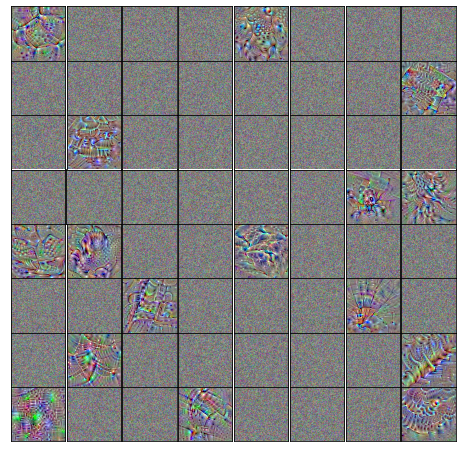

In [ ]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)

outer_grid = fig.add_gridspec(8, 8, wspace=0.0, hspace=0.0)

for i in range(64):
    ax = fig.add_subplot(outer_grid[i])
    #ax.imshow(activations[0,:,:,i])
    visualization_filter(i)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

plt.show()

input images which maximize first 64 filter of block1_conv2

In [ ]:
layer_output = model.get_layer('block1_conv2').output
activation = models.Model(model.input,layer_output)

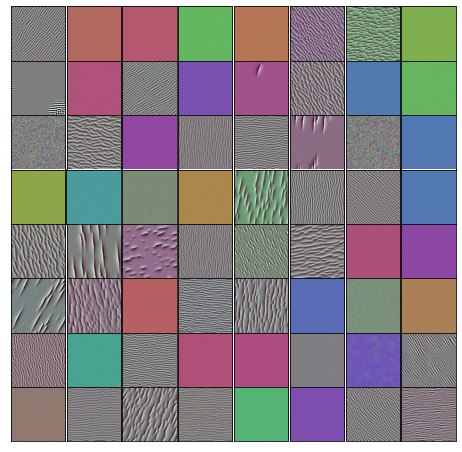

In [ ]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)

outer_grid = fig.add_gridspec(8, 8, wspace=0.0, hspace=0.0)

for i in range(64):
    ax = fig.add_subplot(outer_grid[i])
    #ax.imshow(activations[0,:,:,i])
    visualization_filter(i)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

plt.show()

# **Class Maximization**

loading model

In [ ]:
model=VGG16(include_top=True)

553467904/553467096 [==============================] - 7s 0us/step


creating new model

In [ ]:
new = models.Model(model.input,model.output)

defining class loss 

In [ ]:
def class_loss(image,index):
  output = new(image)
  loss = tf.reduce_mean(output[:,index])
  return loss

defining gradient descent to maximize class loss

In [ ]:
def gradient(image,index):
  for i in range(30):
    with tf.GradientTape()as tape:
        tape.watch(image)
        loss = class_loss(image,index)
    grads = tape.gradient(loss,image)
    grads = tf.math.l2_normalize(grads)

    image+=10*grads
    return loss,image

defining visualizaton fuction to visualize input which maximize given class output

In [ ]:
def visualization_class(index):
  
  image=tf.random.uniform((1,224,224,3))
  for i in range(100):
    loss,image = gradient(image,index)
  img =deprocess_image(image[0].numpy())
  plt.imshow(img)


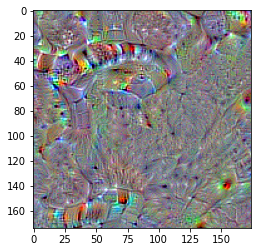

In [ ]:
visualization_class(65)

plotting first 100 input which maximize class

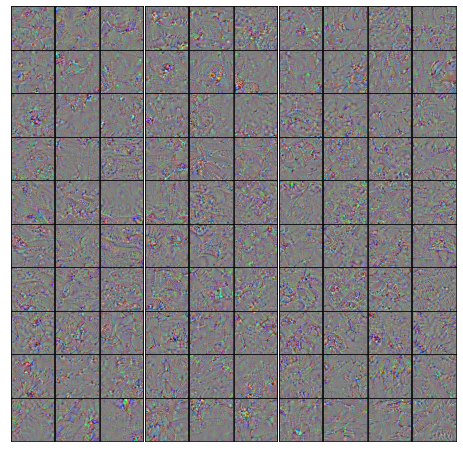

In [ ]:
fig = plt.figure(figsize = (8,8),constrained_layout=False)
outer = fig.add_gridspec(10,10,wspace=0.0,hspace=0.0)
for i in range(100):
  ax = fig.add_subplot(outer[i])
  visualization_class(i)
  ax.set_xticks([])
  ax.set_yticks([])
  fig.add_subplot(ax)
plt.show()

# **Grad Cam visualization**

In [2]:
from tensorflow.keras.applications import Xception

In [3]:
model = Xception()

91889664/91884032 [==============================] - 1s 0us/step


In [4]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [5]:
# first model input to last conv layer
last_layer = model.get_layer('block14_sepconv2_act').output
activations = models.Model(model.input,last_layer)

In [16]:
last_layer.shape[1:]

TensorShape([10, 10, 2048])

In [21]:
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

In [24]:
# second model last conv layer to model top predictions
classifier_input = tf.keras.Input(shape=last_layer.shape[1:])
x = classifier_input
x = model.get_layer('avg_pool')(x)
x = model.get_layer('predictions')(x)
classify = models.Model(classifier_input,x)


In [28]:
img_path = tf.keras.utils.get_file(
    "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
)


4218880/4217496 [==============================] - 0s 0us/step


In [29]:
img_array = tf.keras.preprocessing.image.load_img(img_path,target_size=(299,299,3))
img_array = np.expand_dims(img_array,axis=0)/255

In [41]:
with tf.GradientTape() as tape:
  last_conv_img = activations(img_array)
  tape.watch(last_conv_img)
  preds = classify(last_conv_img)
  top_preds_index = tf.argmax(preds,axis=1)
  top_preds_value = preds[:,top_preds_index.numpy()[0]]
grads = tape.gradient(top_preds_value,last_conv_img)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_img = last_conv_img*pooled_grads

In [42]:
last_conv_img.shape

TensorShape([1, 10, 10, 2048])

In [54]:
heatmap = np.mean(last_conv_img, axis=-1)

In [55]:
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

In [57]:
heatmap.shape

(1, 10, 10)

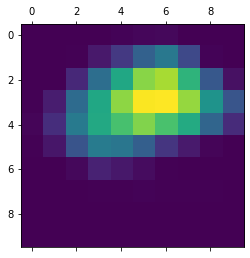

In [58]:
plt.matshow(heatmap[0,:,:])
plt.show()

In [60]:
import matplotlib.cm as cm

In [75]:
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap[0])
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)


In [73]:
from IPython.display import Image

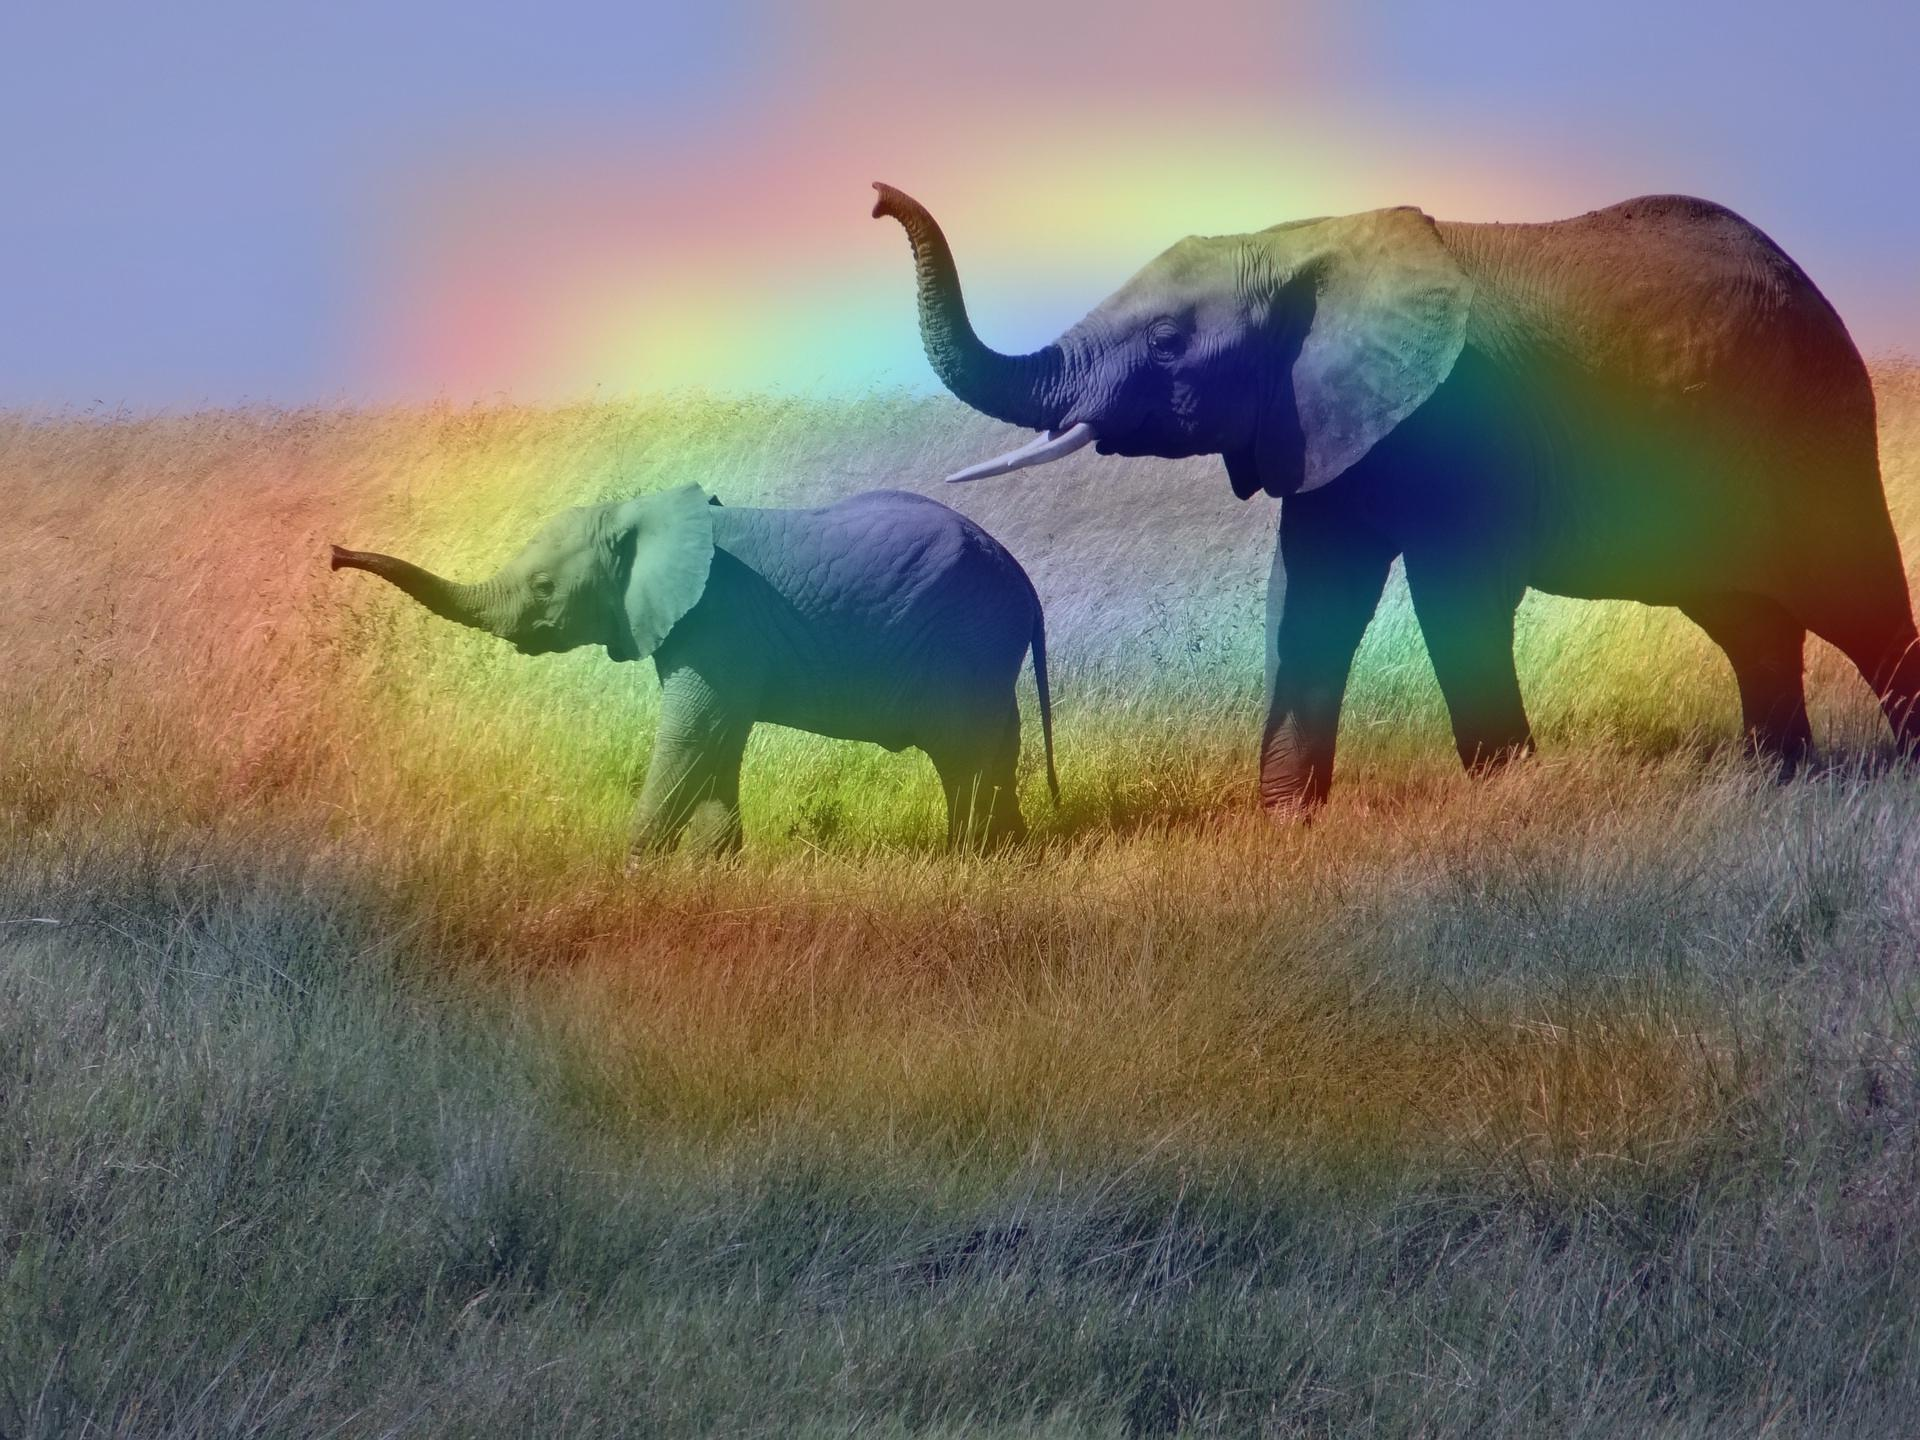

In [76]:
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))